# 📦 Inventory Control as an MDP  
### A Complete End-to-End Learning Notebook

This notebook teaches how to model and solve a **single-product inventory control** problem using **Markov Decision Processes (MDPs)**.

We will:

1. Define the inventory control problem  
2. Formulate it as an MDP  
3. Build a simulation environment  
4. Evaluate a heuristic (order-up-to) policy  
5. Build the full MDP model (transition probabilities + rewards)  
6. Apply **Value Iteration**  
7. Derive the **optimal** ordering policy  
8. Compare heuristic vs. optimal  

# 1. 📘 Problem Overview

You manage a warehouse storing **one product**.  
Each day:

1. Start with inventory $s_t$
2. Choose order quantity $a_t$
3. Ordered units **arrive immediately**
4. Customer demand $D_t$ occurs (Poisson-distributed)
5. You sell up to available inventory
6. Unmet demand is lost (or penalized)
7. Remaining inventory carries to next day

Your goal:

**Maximize long-run expected profit**  
(or equivalently minimize expected long-run cost)

# 2. 🧠 MDP Formulation

## State
Inventory level at start of day:

$$
s \in \{0,1,2,\dots,S_{\max}\}
$$

## Action
Order quantity:

$$
a \in \{0,1,\dots,A_{\max}\}
$$

## Demand
Daily demand is random:

$$
D \sim \text{Poisson}(\lambda)
$$

## Inventory Dynamics

Before demand:

$$
\text{inv\_pre} = \min(S_{\max},\; s + a)
$$

Units sold:

$$
\text{units\_sold} = \min(\text{inv\_pre}, D)
$$

Next state:

$$
s' = \text{inv\_pre} - \text{units\_sold}
$$


In [55]:
# 0. Imports

import numpy as np
import matplotlib.pyplot as plt
from math import exp, factorial


# 3. 💰 Reward Function

Let:

- $p_s$ = selling price  
- $c_p$ = purchase cost  
- $K$ = fixed order cost  
- $h$ = holding cost  
- $p_b$ = penalty for unmet demand  

Revenue:

$$
\text{revenue} = p_s \cdot \text{units\_sold}
$$

Ordering cost:

$$
\text{order\_cost} = 
\begin{cases}
K + c_p a & a>0 \\
0 & a=0
\end{cases}
$$

Holding cost:

$$
\text{holding\_cost} = h \cdot s'
$$

Stockout penalty:

$$
\text{stockout\_cost} = p_b \cdot (D - \text{units\_sold})
$$

Daily reward:

$$
r(s,a,D) = \text{revenue} 
- \text{order\_cost}
- \text{holding\_cost}
- \text{stockout\_cost}
$$


# 4. 🏗️ Creating the Simulation Environment

We build a Gym-like `InventoryEnv`:

- `reset()` returns initial inventory  
- `step(action)` updates inventory & demand  
- `render()` shows the current state  

Used for:

- Monte-Carlo simulation  
- Policy evaluation  
- Q-learning, later if desired  

In [56]:
class InventoryEnv:
    def __init__(
        self,
        max_inventory=20,
        max_order=6,
        holding_cost=1.0,
        stockout_cost=5.0,
        fixed_order_cost=2.0,
        unit_purchase_cost=10.0,
        unit_selling_price=15.0,
        demand_lambda=10.0,
        seed=None,
    ):
        # Parameters
        self.max_inventory = max_inventory
        self.max_order = max_order
        self.holding_cost = holding_cost
        self.stockout_cost = stockout_cost
        self.fixed_order_cost = fixed_order_cost
        self.unit_purchase_cost = unit_purchase_cost
        self.unit_selling_price = unit_selling_price
        self.demand_lambda = demand_lambda

        # RNG
        self.rng = np.random.default_rng(seed)

        # State
        self.inventory = None

        # For render/debug
        self.last_action = None
        self.last_demand = None
        self.last_units_sold = None
        self.last_unmet_demand = None
        self.last_reward = None

    def reset(self, inventory_init=None):
        """
        Reset environment at the beginning of an episode.
        Returns initial state (inventory).
        """
        if inventory_init is None:
            # For simplicity, start from half of max inventory
            self.inventory = self.max_inventory // 2
        else:
            self.inventory = int(inventory_init)

        self.inventory = int(np.clip(self.inventory, 0, self.max_inventory))

        # Clear debug variables
        self.last_action = None
        self.last_demand = None
        self.last_units_sold = None
        self.last_unmet_demand = None
        self.last_reward = None

        return self.inventory

    def _sample_demand(self):
        """
        Sample stochastic demand for the day: Poisson(demand_lambda),
        clipped to a reasonable maximum.
        """
        d = self.rng.poisson(self.demand_lambda)
        max_demand = self.max_inventory + self.max_order
        d = int(np.clip(d, 0, max_demand))
        return d

    def step(self, action):
        """
        Take an action (order quantity) and simulate one day.
        Returns: next_state, reward, done, info
        """
        # 1. Clip action
        order_qty = int(np.clip(action, 0, self.max_order))

        # 2. Arrivals (immediate)
        arrivals = order_qty

        # 3. Update inventory with arrivals, respecting capacity
        self.inventory = min(self.max_inventory, self.inventory + arrivals)

        # 4. Sample demand
        demand = self._sample_demand()

        # 5. Compute sales and unmet demand
        units_sold = min(self.inventory, demand)
        unmet_demand = demand - units_sold
        self.inventory = self.inventory - units_sold  # end-of-day inventory

        # 6. Compute reward
        # Revenue
        revenue = self.unit_selling_price * units_sold

        # Ordering cost (fixed + variable if any order)
        if order_qty > 0:
            order_cost = self.fixed_order_cost + self.unit_purchase_cost * order_qty
        else:
            order_cost = 0.0

        # Holding cost
        holding_cost = self.holding_cost * self.inventory

        # Stockout penalty
        stockout_cost = self.stockout_cost * unmet_demand

        reward = revenue - order_cost - holding_cost - stockout_cost

        # Debug fields
        self.last_action = order_qty
        self.last_demand = demand
        self.last_units_sold = units_sold
        self.last_unmet_demand = unmet_demand
        self.last_reward = reward

        # Next state is current inventory
        next_state = self.inventory
        done = False  # infinite horizon; no terminal state by default

        info = {
            "order_qty": order_qty,
            "arrivals": arrivals,
            "inventory_end": self.inventory,
            "demand": demand,
            "units_sold": units_sold,
            "unmet_demand": unmet_demand,
            "reward": reward,
        }

        return next_state, reward, done, info

    def render(self):
        """
        Print a detailed snapshot of the current environment status.
        """
        print("=== ENVIRONMENT STATUS ===")
        print(f"Inventory         : {self.inventory}")
        if self.last_action is not None:
            print(f"Last action       : {self.last_action}")
        if self.last_demand is not None:
            print(f"Last demand       : {self.last_demand}")
        if self.last_units_sold is not None:
            print(f"Units sold        : {self.last_units_sold}")
        if self.last_unmet_demand is not None:
            print(f"Unmet demand      : {self.last_unmet_demand}")
        if self.last_reward is not None:
            print(f"Last reward       : {self.last_reward:.2f}")
        print("==========================\n")


# 5. 🎯 Heuristic Policy: Order-Up-To (Base-Stock) Policy

A common industrial policy:

$$
a(s) = \max(0, S - s)
$$

Interpretation:

- If inventory is below target level $S$, order enough to reach $S$
- If inventory is above $S$, order nothing

We test many values of $S$ by simulation:

- simulate many episodes  
- measure average total reward  
- pick the best $S$  

This gives us a baseline for comparison with the optimal policy.

In [57]:
def order_up_to_policy(state, S):
    """
    Base-stock policy: order enough to reach level S (capped by max_order inside env).
    """
    order_qty = max(0, S - state)
    return order_qty


In [58]:
def run_episode(env, level_S, horizon=100):
    """
    Run a single episode of length `horizon` days using an order-up-to policy with level S.
    Returns total reward.
    """
    state = env.reset()
    total_reward = 0.0

    for t in range(horizon):
        action = order_up_to_policy(state, level_S)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state
        if done:
            break

    return total_reward


In [59]:
# Evaluate a single S just to test that everything runs
env = InventoryEnv(seed=0)  # small environment
test_S = 12
rewards = [run_episode(env, test_S) for _ in range(10)]
print("Example episode rewards (S = 12):", rewards)
print("Average:", np.mean(rewards))


Example episode rewards (S = 12): [633.0, 872.0, 677.0, 1029.0, 920.0, 835.0, 983.0, 1295.0, 1093.0, 985.0]
Average: 932.2


In [60]:
env = InventoryEnv(seed=123)

S_values = list(range(0, env.max_inventory + 1, 2))  # 0, 2, 4, ..., max_inventory
avg_rewards = []

num_episodes = 300
horizon = 100

for S in S_values:
    returns = [run_episode(env, S, horizon=horizon) for _ in range(num_episodes)]
    avg_rewards.append(np.mean(returns))

avg_rewards = np.array(avg_rewards)


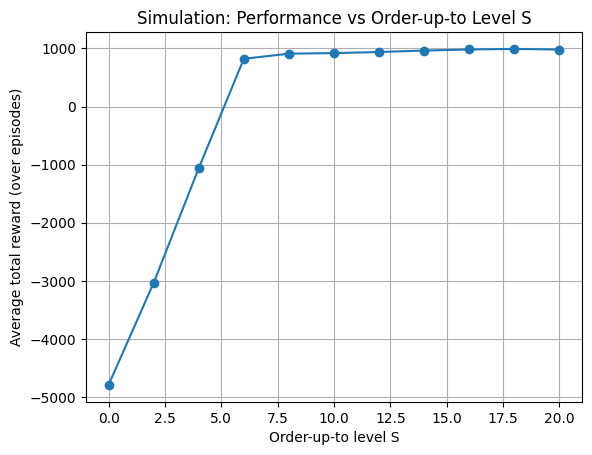

Best S (by simulation): 18 with avg reward 991.73


In [61]:
plt.figure()
plt.plot(S_values, avg_rewards, marker="o")
plt.xlabel("Order-up-to level S")
plt.ylabel("Average total reward (over episodes)")
plt.title("Simulation: Performance vs Order-up-to Level S")
plt.grid(True)
plt.show()

best_idx = np.argmax(avg_rewards)
print(f"Best S (by simulation): {S_values[best_idx]} with avg reward {avg_rewards[best_idx]:.2f}")


# 6. 🧩 Building the Tabular MDP Model

To apply Value Iteration, we need:

- Transition probabilities $P(s' \mid s,a)$  
- Expected rewards $R(s,a)$  

## 6.1 Transition Probabilities

For a given $(s,a)$:

1. Compute  
   $$
   \text{inv\_pre} = \min(S_{\max}, s + a)
   $$

2. For each demand $d=0,1,\ldots,D_{\max}$:
   - Probability:
     $$
     p_d = P(D=d)
     $$
   - Units sold:
     $$
     u = \min(\text{inv\_pre}, d)
     $$
   - Next state:
     $$
     s' = \text{inv\_pre} - u
     $$
   - Accumulate:
     $$
     P(s'|s,a) \mathrel{+}= p_d
     $$

Because demand is Poisson:

$$
p_d = e^{-\lambda} \frac{\lambda^d}{d!}
$$

---

## 6.2 Expected Reward

Expected reward:

$$
R(s,a) = \sum_d p_d \; r(s,a,d)
$$

We compute this inside the same loop used for transitions.


In [62]:
# Build model P and R based on the environment parameters

env_model = InventoryEnv(seed=42)
max_inventory = env_model.max_inventory
max_order = env_model.max_order

states = np.arange(max_inventory + 1)  # 0..max_inventory
actions = np.arange(max_order + 1)     # 0..max_order
num_states = len(states)
num_actions = len(actions)

P = np.zeros((num_states, num_actions, num_states))
R = np.zeros((num_states, num_actions))

D_max = max_inventory + max_order
lam = env_model.demand_lambda

def poisson_pmf(d, lam):
    return exp(-lam) * (lam ** d) / factorial(d)

for s in states:
    for a in actions:

        s_idx = s
        a_idx = a

        inv_pre = min(max_inventory, s + a)

        for d in range(D_max + 1):
            p_d = poisson_pmf(d, lam)

            # Sales and next state
            units_sold = min(inv_pre, d)
            unmet_demand = d - units_sold
            s_next = inv_pre - units_sold  # end-of-day inventory
            s_next_idx = s_next  # directly usable as index (0..max_inventory)

            # Reward for this (s,a,d)
            revenue = env_model.unit_selling_price * units_sold

            if a > 0:
                order_cost = env_model.fixed_order_cost + env_model.unit_purchase_cost * a
            else:
                order_cost = 0.0

            holding_cost = env_model.holding_cost * s_next
            stockout_cost = env_model.stockout_cost * unmet_demand

            r = revenue - order_cost - holding_cost - stockout_cost

            # Accumulate
            P[s_idx, a_idx, s_next_idx] += p_d
            R[s_idx, a_idx] += p_d * r

# Optional sanity check: rows of P should sum to ~1
row_sums = P.sum(axis=2)
print("Row sums (should be ~1):")
print(row_sums[:5, :5])  # small slice


Row sums (should be ~1):
[[0.99999358 0.99999358 0.99999358 0.99999358 0.99999358]
 [0.99999358 0.99999358 0.99999358 0.99999358 0.99999358]
 [0.99999358 0.99999358 0.99999358 0.99999358 0.99999358]
 [0.99999358 0.99999358 0.99999358 0.99999358 0.99999358]
 [0.99999358 0.99999358 0.99999358 0.99999358 0.99999358]]


# 7. 🧮 Value Iteration

To find:

- Optimal value function $V^*(s)$  
- Optimal ordering policy $\pi^*(s)$  

We iterate the Bellman optimality equation:

$$
V_{k+1}(s) = 
\max_a 
\Big[
R(s,a) + \gamma \sum_{s'} P(s'|s,a) V_k(s')
\Big]
$$

Stop when:

$$
|V_{k+1}(s) - V_k(s)| < \theta
$$

Then optimal policy:

$$
\pi^*(s) = 
\arg\max_a 
\Big[
R(s,a) + \gamma \sum_{s'} P(s'|s,a) V^*(s')
\Big]
$$

This produces a **state-dependent** optimal ordering policy.

In [63]:
def value_iteration(P, R, gamma=0.99, theta=1e-6):
    """
    P: [num_states, num_actions, num_states]
    R: [num_states, num_actions]
    """
    num_states, num_actions, _ = P.shape

    V = np.zeros(num_states)

    while True:
        delta = 0.0
        V_new = np.zeros_like(V)

        for s in range(num_states):
            Q_values = []
            for a in range(num_actions):
                q = R[s, a] + gamma * np.sum(P[s, a, :] * V)
                Q_values.append(q)
            V_new[s] = max(Q_values)
            delta = max(delta, abs(V_new[s] - V[s]))

        V = V_new

        if delta < theta:
            break

    # Extract optimal policy
    policy = np.zeros(num_states, dtype=int)

    for s in range(num_states):
        best_q = -1e18
        best_a = 0
        for a in range(num_actions):
            q = R[s, a] + gamma * np.sum(P[s, a, :] * V)
            if q > best_q:
                best_q = q
                best_a = a
        policy[s] = best_a

    return V, policy


In [64]:
V_star, pi_star = value_iteration(P, R, gamma=0.99, theta=1e-6)
print("Optimal value function V* (first few):")
print(V_star[:10])

print("\nOptimal policy π*(s) = order quantity at inventory s:")
for s in range(num_states):
    print(f"s = {s:2d} -> a* = {pi_star[s]}")


Optimal value function V* (first few):
[783.15433862 802.9528729  822.60100578 842.04832213 861.25181714
 880.1806596  898.81691692 917.15300774 935.1876402  952.92158797]

Optimal policy π*(s) = order quantity at inventory s:
s =  0 -> a* = 6
s =  1 -> a* = 6
s =  2 -> a* = 6
s =  3 -> a* = 6
s =  4 -> a* = 6
s =  5 -> a* = 6
s =  6 -> a* = 6
s =  7 -> a* = 6
s =  8 -> a* = 6
s =  9 -> a* = 6
s = 10 -> a* = 6
s = 11 -> a* = 6
s = 12 -> a* = 6
s = 13 -> a* = 6
s = 14 -> a* = 6
s = 15 -> a* = 5
s = 16 -> a* = 4
s = 17 -> a* = 3
s = 18 -> a* = 2
s = 19 -> a* = 1
s = 20 -> a* = 0


# 8. 📈 Visualizing the Optimal Policy

The resulting $\pi^*(s)$ usually looks like a **base-stock policy**:

- For small $s$, order heavily  
- For mid $s$, order moderately  
- For large $s$, stop ordering  

This shape is consistent with classic results in inventory theory.

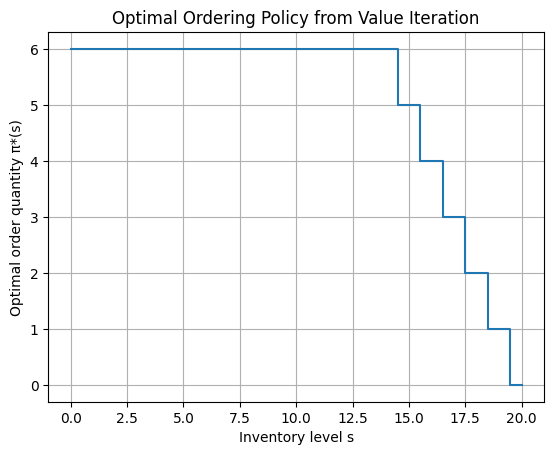

In [65]:
plt.figure()
plt.step(states, pi_star, where="mid")
plt.xlabel("Inventory level s")
plt.ylabel("Optimal order quantity π*(s)")
plt.title("Optimal Ordering Policy from Value Iteration")
plt.grid(True)
plt.show()


# 9. 🧪 Comparing Heuristic vs. Optimal Policy

We compare:

1. Best $S$ from simulation (order-up-to policy)
2. Optimal policy $\pi^*$ from value iteration

Often the optimal policy behaves like:

$$
\pi^*(s) = \max(0, S^* - s)
$$

for some optimal $S^*$.

This validates:

- The simulation method  
- The DP method  
- The correctness of the environment  


In [66]:
def dp_policy_from_pi(state, pi_array):
    """
    Deterministic policy built from π*(s) array.
    """
    return pi_array[state]

def run_episode_with_dp_policy(env, pi_array, horizon=100):
    state = env.reset()
    total_reward = 0.0
    for t in range(horizon):
        action = dp_policy_from_pi(state, pi_array)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state
        if done:
            break
    return total_reward

env_test = InventoryEnv(seed=999)
dp_returns = [run_episode_with_dp_policy(env_test, pi_star) for _ in range(300)]
print("Average total reward with DP optimal policy:", np.mean(dp_returns))


Average total reward with DP optimal policy: 972.04


# 10. 📚 Summary

In this notebook you learned:

- How inventory problems map cleanly to MDPs  
- How to build a Gym-like environment  
- How to simulate and evaluate policies  
- How to build the full tabular MDP model  
- How to apply Value Iteration  
- Why optimal policies often follow a base-stock structure  

This gives strong foundations for:

- Reinforcement learning  
- Operations research  
- Stochastic control  
- Approximate DP  
- Supply-chain optimization  

---

# 11. 🚀 Next Extensions (Optional)

- Lead times  
- Backorders (instead of lost sales)  
- Multi-product  
- Q-learning, SARSA  
- DQN / PPO (deep RL)  
- Continuous state approximations  
- Inventory with perishability  
